In [1]:
# -*- coding: utf-8 -*-
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings   
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [2]:
# pretty display of variables
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Loading in Data

In [3]:
# Loading in data

class Food11Dataset(Dataset):
    """Food 11 dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.index_file = pd.read_csv(csv_file) # first column: image_name (i.e. 0809-personal.jpg)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.index_file)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.index_file.iloc[idx, 0]) # get filepath to image
        image = io.imread(img_name)
        label = self.index_file.iloc[idx, 1] # get the labels

        if self.transform:
            image = self.transform(image)

        return image, label

In [4]:
trainset = Food11Dataset(csv_file='../data/Food-11/train-index.csv',
                         root_dir='../data/Food-11/training/')

testset = Food11Dataset(csv_file='../data/Food-11/evaluate-index.csv',
                         root_dir='../data/Food-11/evaluation/')

In [81]:
len(trainset)

9866

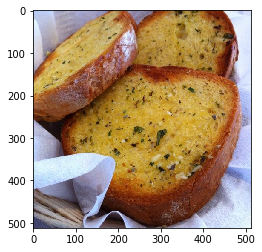

In [6]:
plt.imshow(io.imread('../data/Food-11/training/0_0.jpg'))

(512, 512, 3)
0


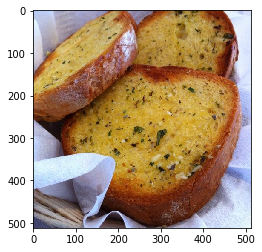

In [7]:
img, lab = trainset.__getitem__(0)
plt.imshow(img)
print(img.shape)
print(lab)

0 (512, 512, 3)


Text(0.5,1,'Sample #0')

(0.0, 1.0, 0.0, 1.0)

1 (512, 512, 3)


Text(0.5,1,'Sample #1')

(0.0, 1.0, 0.0, 1.0)

2 (341, 512, 3)


Text(0.5,1,'Sample #2')

(0.0, 1.0, 0.0, 1.0)

3 (512, 512, 3)


Text(0.5,1,'Sample #3')

(0.0, 1.0, 0.0, 1.0)

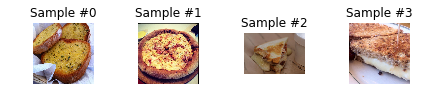

In [9]:
fig = plt.figure()

for i in range(len(trainset)):
    img, lab = trainset[i]

    print(i, img.shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(img)

    if i == 3:
        plt.show()
        break


## Transform

In [10]:
# Transforms
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, image):

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        return img


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, image):

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        return image


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, image):

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return torch.from_numpy(image)

In [42]:
scale = Rescale(64)
crop = RandomCrop(56)
composed = transforms.Compose([scale,crop])

# Apply each of the above transforms on sample.
fig = plt.figure()
img, lab = trainset[0]

<Figure size 432x288 with 0 Axes>

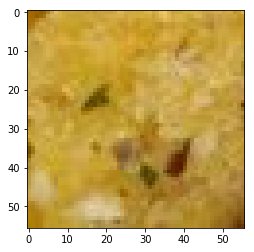

In [43]:
plt.imshow(crop(img))

Text(0.5,1,'Rescale')

Text(0.5,1,'RandomCrop')

Text(0.5,1,'Compose')

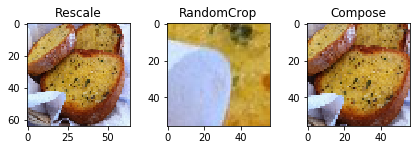

In [45]:
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(img)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    plt.imshow(transformed_sample)

plt.show()

## Iterating through dataset

In [63]:
# Ready to load + transform images
my_transform = transforms.Compose([
                                   Rescale(64),
                                   RandomCrop(32),
                                   ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                   ])

In [139]:
trainset = Food11Dataset(csv_file='../data/Food-11/train-index.csv',
                         root_dir='../data/Food-11/training/',
                        transform=my_transform)

testset = Food11Dataset(csv_file='../data/Food-11/evaluate-index.csv',
                         root_dir='../data/Food-11/evaluation/',
                       transform=my_transform)

In [140]:
trainloader = DataLoader(trainset, batch_size=4,
                         shuffle=True, num_workers=0) #num_workers=0 because can't parallelize in Windows
testloader = DataLoader(testset, batch_size=4,
                        shuffle=True, num_workers=0)
classes = ('bread', 'dairy-product', 'dessert', 'egg', 'fried-food', 'meat', 'noodles/pasta', 'rice', 'seafood', 'soup', 'vegetable', 'fruit') # tuple that I can index into

In [66]:
type(trainloader)

torch.utils.data.dataloader.DataLoader

seafood vegetable dessert vegetable


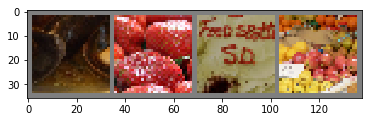

In [67]:
dataiter = iter(trainloader)
imgs, labs = dataiter.next()

# show images
imshow(utils.make_grid(imgs))
# print labels
print(' '.join('%5s' % classes[labs[j]] for j in range(4)))

In [68]:
imgs.size()

torch.Size([4, 3, 32, 32])

In [74]:
imgs.type()

'torch.DoubleTensor'

#  Untuned Neural Net for Image Classification

### Definition

In [78]:
# Define Neural network
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 11)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [79]:
# Define Loss function and optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Training

In [80]:
# Train the network
for epoch in range(2):  # loop over the dataset multiple times
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data # labels come from a csv(?)
        inputs = inputs.float()
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        #### need to understand this part more
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.274
[2,  2000] loss: 2.216
Finished Training


### Inspecting output

GroundTruth:  dessert  meat bread vegetable


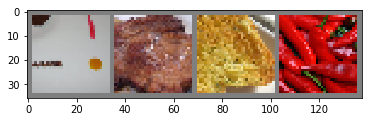

In [94]:
# Test network on the test data
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [96]:
# predict outcome by taking the class w/ the max energy per photo
outputs = net(images.float())
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    egg  soup  soup  meat


In [101]:
outputs

tensor([[ 0.2472,  0.5750,  0.6809,  0.9219, -0.4081,  0.1454, -0.8830, -1.1131,
         -0.0471,  0.5565, -0.5035],
        [ 0.7361, -1.1062,  0.7648,  0.0404,  0.6645,  0.6938, -0.6260, -1.4793,
          0.0770,  0.8283,  0.0372],
        [ 0.6994, -0.4835,  0.1304,  0.3993,  0.5131, -0.3477, -0.2466, -0.5221,
         -0.5142,  0.9262, -0.4565],
        [ 1.2039, -2.7196,  2.5065, -0.4591,  1.1324,  2.8083, -1.7140, -4.1599,
          1.3435,  1.1114,  0.9902]], grad_fn=<ThAddmmBackward>)

In [100]:
torch.max(outputs,1)

(tensor([0.9219, 0.8283, 0.9262, 2.8083], grad_fn=<MaxBackward0>),
 tensor([3, 9, 9, 5]))

In [137]:
predicted

tensor([2, 2, 2, 9])

In [133]:
predicted.type()

'torch.LongTensor'

In [141]:
# get all predicted values
Yhat = torch.tensor([], dtype=torch.long)
with torch.no_grad():
    for i_batch, data in enumerate(testloader):
        images, labels = data
        outputs = net(images.float())
        _, predicted = torch.max(outputs.data, 1)
        Yhat = torch.cat((Yhat, predicted))
        
        if i_batch % 100 == 0:
            print(Yhat.size())

torch.Size([4])
torch.Size([404])
torch.Size([804])
torch.Size([1204])
torch.Size([1604])
torch.Size([2004])
torch.Size([2404])
torch.Size([2804])
torch.Size([3204])


In [142]:
Yhat.size()

torch.Size([3347])

In [86]:
# Total accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.float())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 23 %


In [121]:
len(testset)

3347

In [89]:
# Categorical accuracy + make graph
n = 11
class_correct = list(0. for i in range(n))
class_total = list(0. for i in range(n))

In [2]:
# with torch.no_grad(): # disabling gradient calculation to reduce memory
#     for i_batch, data in enumerate(testloader):
#         images, labels = data
#         outputs = net(images.float())
#         _, predicted = torch.max(outputs, 1)
#         c = (predicted == labels).squeeze()
        
#         for i in range(4):
#             label = labels[i]
#             class_correct[label] += c[i].item()
#             class_total[label] += 1
#         if i_batch == 100:
#             print(labels)
#             print(predicted)
#             print(c)
#             print(class_correct)


# for i in range(n):
#     print('Accuracy of %5s : %2d %%' % (
#                                         classes[i], 100 * class_correct[i] / class_total[i]))

### Storing Nnet values for future use

In [144]:
print("Model's state_dict:")
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
# for var_name in optimizer.state_dict():
#     print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
conv1.weight 	 torch.Size([6, 3, 5, 5])
conv1.bias 	 torch.Size([6])
conv2.weight 	 torch.Size([16, 6, 5, 5])
conv2.bias 	 torch.Size([16])
fc1.weight 	 torch.Size([120, 400])
fc1.bias 	 torch.Size([120])
fc2.weight 	 torch.Size([84, 120])
fc2.bias 	 torch.Size([84])
fc3.weight 	 torch.Size([11, 84])
fc3.bias 	 torch.Size([11])
Optimizer's state_dict:


In [148]:
net.state_dict()['conv1.bias']

tensor([ 0.1158,  0.0227,  0.1451,  0.0033, -0.0611,  0.0731])

In [147]:
torch.save(net.state_dict(), '../models/untuned-mvp.pt')